In [7]:
!pip install mne

In [8]:
import mne
import numpy as np

file_path = 'chb01_03.edf'
raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)

sfreq = raw.info['sfreq']

seizure_start, seizure_end = 2996, 3036
healthy_start, healthy_end = 2500, 2540

seizure_start_sample = int(seizure_start * sfreq)
seizure_end_sample = int(seizure_end * sfreq)
healthy_start_sample = int(healthy_start * sfreq)
healthy_end_sample = int(healthy_end * sfreq)

seizure_data = raw[:, seizure_start_sample:seizure_end_sample][0]
healthy_data = raw[:, healthy_start_sample:healthy_end_sample][0]

batch_size = int(3 * sfreq)

def extract_batches(data, batch_size):
    return [data[:, i:i + batch_size] for i in range(0, data.shape[1], batch_size) if i + batch_size <= data.shape[1]]

seizure_batches = extract_batches(seizure_data, batch_size)
healthy_batches = extract_batches(healthy_data, batch_size)

len(seizure_batches), len(healthy_batches)


<ipython-input-8-e7fc5d513cc2>:5: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)


(13, 13)

In [9]:
from scipy.signal import welch
from scipy.stats import skew, kurtosis

def compute_features(batch, sfreq):
    features = {}

    features['mean'] = np.mean(batch, axis=1)
    features['variance'] = np.var(batch, axis=1)
    features['skewness'] = skew(batch, axis=1)
    features['kurtosis'] = kurtosis(batch, axis=1)

    freqs, psd = welch(batch, sfreq, nperseg=256)


    bands = {'delta': (1, 4), 'theta': (4, 8), 'alpha': (8, 12), 'beta': (12, 30), 'gamma': (30, 100)}

    for band, (low, high) in bands.items():
        idx_band = np.logical_and(freqs >= low, freqs <= high)
        features[f'{band}_power'] = np.mean(psd[:, idx_band], axis=1)

    return features

seizure_features = [compute_features(batch, sfreq) for batch in seizure_batches]
healthy_features = [compute_features(batch, sfreq) for batch in healthy_batches]

seizure_features[0], healthy_features[0]

({'mean': array([ 6.91391941e-07,  2.29192104e-06,  2.88003663e-06, -3.64265364e-07,
         -5.44515670e-06,  3.24023199e-06,  3.83547009e-06,  3.54955230e-06,
         -1.59442409e-06, -4.57875458e-07,  7.17083842e-06, -1.31262719e-05,
         -2.84900285e-08,  9.93386243e-06,  4.98066748e-07, -1.85973748e-05,
          3.09371184e-06,  2.70248270e-06, -2.48931624e-06, -4.27859178e-07,
          1.39550265e-06,  4.64794465e-06,  4.98066748e-07]),
  'variance': array([2.13629340e-09, 5.95154496e-10, 6.20418547e-10, 3.20861525e-10,
         2.25115749e-09, 9.85685231e-10, 5.93763822e-10, 8.17471995e-10,
         3.34926787e-09, 2.76408265e-09, 1.49296503e-09, 1.53981563e-09,
         2.08694263e-09, 1.10159607e-09, 2.25044728e-09, 1.55886179e-09,
         2.66964653e-09, 1.50016924e-09, 6.20418547e-10, 2.96037697e-10,
         3.22241535e-09, 6.49443377e-10, 2.25044728e-09]),
  'skewness': array([ 0.04986397,  0.2701918 ,  0.2351477 ,  0.22576301,  0.06556002,
         -0.00963259,  

In [10]:
import pandas as pd

def features_to_dataframe(features, label):
    df_list = []
    for feature_dict in features:
        df = pd.DataFrame(feature_dict)
        df['label'] = label
        df_list.append(df)
    return pd.concat(df_list, ignore_index=True)

df_seizure = features_to_dataframe(seizure_features, 1)
df_healthy = features_to_dataframe(healthy_features, 0)

df_combined = pd.concat([df_seizure, df_healthy], ignore_index=True)

df_combined = df_combined.sample(frac=1).reset_index(drop=True)

df_combined.head()

,mean,variance,skewness,kurtosis,delta_power,theta_power,alpha_power,beta_power,gamma_power,label
0,-7.468457e-07,4.805519e-10,-0.175400,-0.328705,9.711051e-11,1.980781e-11,8.278922e-12,1.228212e-12,2.535112e-13,0
1,1.188950e-06,7.829306e-09,0.011055,-0.268227,1.187063e-09,2.573347e-10,1.957100e-11,2.734567e-11,1.045623e-11,1
2,-1.312576e-06,4.861416e-09,-0.659736,0.429104,9.311376e-10,2.234374e-10,2.759713e-11,2.885514e-12,1.938900e-13,1
3,-2.030423e-06,4.098939e-10,0.202621,1.289918,4.378917e-11,3.506197e-11,9.420549e-12,2.677455e-12,1.863664e-13,0
4,-1.487078e-06,2.618532e-10,0.099535,0.013063,2.326997e-11,1.392092e-11,3.619568e-12,1.184533e-12,3.752689e-13,0


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

X = df_combined.drop('label', axis=1)
y = df_combined['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

conf_matrix, report

(array([[67, 26],
        [22, 65]]),
 '              precision    recall  f1-score   support\n\n           0       0.75      0.72      0.74        93\n           1       0.71      0.75      0.73        87\n\n    accuracy                           0.73       180\n   macro avg       0.73      0.73      0.73       180\nweighted avg       0.73      0.73      0.73       180\n')

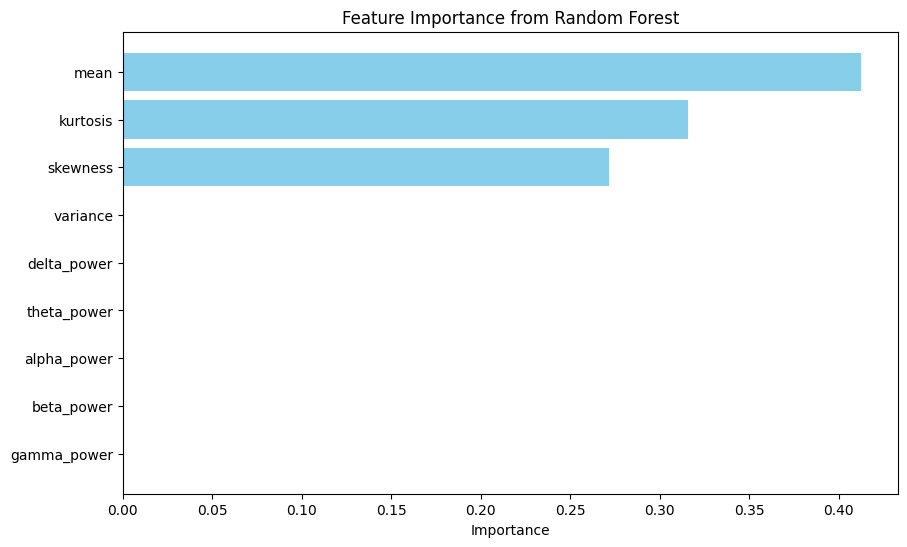

In [12]:
import matplotlib.pyplot as plt

feature_importances = rf_classifier.feature_importances_
features = X_train.columns

df_feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(df_feature_importances['Feature'], df_feature_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()
plt.show()

In [13]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(rf_classifier, X, y, cv=5, scoring='accuracy')

cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

cv_scores, cv_mean, cv_std

(array([0.74166667, 0.84166667, 0.7       , 0.76470588, 0.74789916]),
 0.7591876750700279,
 0.046412997882396334)